<h2>Import Packages and Data</h2>

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("landslide_data.csv") 

<h2>Define Functions</h2>

Not all functions will be explained in great detail, but the build_multi_output_model function will, because of its importance throughout the notebook:

The function builds a neural network comprised of essentially 5 parts:

1) The input layer

2) The first collection of hidden layers

3) The first output

4) The second collection of hidden layers

5) The second output


Each non-output layer has a dropout layer following it (dropout rate = 0.2), and all layers have an orthagonal kernel initializer, with the exceptino of the input layer. L1 and L2 regularisation is used for all hidden layers. 

The function requires being passed the number of layers in the first collection of hidden layers (stage_1_hidden_layers), and the number of neurons in each layer (stage_1_neurons), as well as the same for the second stage of hidden layers. The activation functions for the first stage are rely, and 'leaky relu' for the second stage (this was done to combat the somehat common "dying relu" problem). The activation functions for the outputs are sigmoid and softmax, corresponding to the output formats required. 

In [3]:
def build_muti_output_model(stage_1_hidden_layers, stage_2_hidden_layers, 
                            stage_1_neurons, stage_2_neurons):
    input_size=19
    stage1_counter = 0
    stage2_counter = 0
    
    input_layer = keras.layers.Input(input_size, 
                                     name="input")

    while stage1_counter < (stage_1_hidden_layers):
        if stage1_counter == 0:
            x = keras.layers.Dense(stage_1_neurons, activation="relu", 
                                   kernel_initializer=tf.keras.initializers.Orthogonal(),
                                   kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
                                  )(input_layer)
            x = keras.layers.Dropout(0.2)(x)
            stage1_counter += 1
        else:
            x = keras.layers.Dense(stage_1_neurons, activation="relu",
                                  kernel_initializer=tf.keras.initializers.Orthogonal(),
                                  kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
                                  )(x)
            x = keras.layers.Dropout(0.2)(x)
            stage1_counter += 1
        
    count_output = keras.layers.Dense(1, activation="sigmoid",
                                      kernel_initializer=tf.keras.initializers.Orthogonal(),
                                      name="count_output")(x)
    
    while stage2_counter < (stage_2_hidden_layers):
        if stage1_counter == 0:
            x = keras.layers.Dense(stage_2_neurons, activation=tf.keras.layers.LeakyReLU(alpha=0.1), 
                                   kernel_initializer=tf.keras.initializers.Orthogonal(),
                                   kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(count_output)
            x = keras.layers.Dropout(0.2)(x)
            stage2_counter += 1
        else:
            x = keras.layers.Dense(stage_2_neurons, activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                                  kernel_initializer=tf.keras.initializers.Orthogonal(),
                                  kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
            x = keras.layers.Dropout(0.2)(x)
            stage2_counter += 1
    
    class_output = keras.layers.Dense(4, activation="softmax",
                                      kernel_initializer=tf.keras.initializers.Orthogonal(),
                                      name="class_output")(x)


    model = keras.Model(inputs=input_layer, outputs=[count_output, class_output]) 

    return model

In [4]:
# Monte carlo approach to finding optimal hyper parameters

def monte_carlo_tuning(x_train, y_train_1, y_train_2, 
                       first_stage_hl, second_stage_hl,
                       first_stage_n, second_stage_n,
                       runs=10, n_samples=1):
    min_loss = 0.0
    min_count_loss = 0.0
    min_area_loss = 0.0
    max_conf = []

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          mode='min', verbose=0, patience=0, restore_best_weights=True)

    config_cache_loss = {}
    config_cache_count = {}
    config_cache_area = {}
    
    for _ in tqdm(range(runs)):
        
        configuration = generate_configuration(first_stage_hl, second_stage_hl,
                                      first_stage_n, second_stage_n)
        
        if all(configuration) not in config_cache_loss:
            loss = 0.0
            count_loss = 0.0
            area_loss = 0.0
            
            for _ in range(n_samples):
                model = build_muti_output_model(configuration[0], configuration[1],
                                               configuration[2], configuration[3])

                model.compile(loss=["binary_crossentropy", "mse"],
                              optimizer="adam")


                history = model.fit(x_train, [y_train_1, y_train_2], 
                    epochs=5,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=15)],
                    verbose=0)
                
                loss       += history.history['val_loss'][-1]
                count_loss += history.history['val_count_output_loss'][-1]
                area_loss  += history.history['val_area_output_loss'][-1]
            loss        = loss/n_samples
            count_loss  = count_loss/n_samples
            area_loss   = area_loss/n_samples

            config_cache_loss[str(configuration)]  = loss
            config_cache_count[str(configuration)] = count_loss
            config_cache_area[str(configuration)]  = area_loss

    return config_cache_loss, config_cache_count, config_cache_area

In [5]:
# given a datalist and a number of breakpoints, this function finds the break point values such that the
# variance in each category is minimised. This code is inspired by: https://gist.github.com/drewda/1299198
# The code at the link provided does not work properly however, and I have made changes here to fix it. 

def getJenksBreaks(dataList, numClass):
    dataList = list(dataList)
    dataList.sort()
    mat1 = []
    for i in range(0,len(dataList)+1):
        temp = []
        for j in range(0,numClass+1):
            temp.append(0)
        mat1.append(temp)
    mat2 = []
    for i in range(0,len(dataList)+1):
        temp = []
        for j in range(0,numClass+1):
            temp.append(0)
        mat2.append(temp)
    for i in range(1,numClass+1):
        mat1[1][i] = 1
        mat2[1][i] = 0
        for j in range(2,len(dataList)+1):
            mat2[j][i] = float('inf')
    v = 0.0
    for l in range(2,len(dataList)+1):
        s1 = 0.0
        s2 = 0.0
        w = 0.0
        for m in range(1,l+1):
            i3 = l - m + 1
            val = float(dataList[i3-1])
            s2 += val * val
            s1 += val
            w += 1
            v = s2 - (s1 * s1) / w
            i4 = i3 - 1
            if i4 != 0:
                for j in range(2,numClass+1):
                    if mat2[l][j] >= (v + mat2[i4][j - 1]):
                        mat1[l][j] = i3
                        mat2[l][j] = v + mat2[i4][j - 1]
        mat1[l][1] = 1
        mat2[l][1] = v
    k = len(dataList)

    breaks = []
    for i in range(0,numClass+1):
        breaks.append(min(dataList))
    countNum = numClass

    while countNum >= 2:#print "rank = " + str(mat1[k][countNum])
        id = int((mat1[k][countNum]) - 2)
        value = dataList[id]
        breaks.append(value)
        k = int((mat1[k][countNum] - 1))
        countNum -= 1

    breaks.append(max(dataList))
    breaks = list(set(breaks))
    breaks.sort()
    return(breaks)

    # The first output number is the smallest value in the input
    # Following output numbers are inclusive upper bounds

In [6]:
# These functions are used to determine the goodness of variance fit, determining how well the function above
# performed (in other words, it measures how well using a specific number of breakpoints applies to the data)
# This code is informed by a stack exchange comment availible at this link:
# https://stats.stackexchange.com/questions/143974/jenks-natural-breaks-in-python-how-to-find-the-optimum-number-of-breaks

def goodness_of_variance_fit(array, nclasses):
    
        classes = getJenksBreaks(array, nclasses)
        classified = np.array([classify(i, classes) for i in array])
        maxz = max(classified)
        zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]
        sdam = np.sum((array - array.mean()) ** 2)
        array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]
        sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])
        gvf = (sdam - sdcm) / sdam
    
        return gvf, classes
    
def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

In [7]:
# This function iterates over various numbers of breakpoints and uses the function above to find the best 
# number of break points

def optimal_classes(data, gvf_threshold, min_classes, max_classes):

    gvf= 0.0
    nclasses = min_classes

    while gvf < gvf_threshold:
            gvf, classes = goodness_of_variance_fit(data, nclasses)
            if gvf < gvf_threshold:
                gvf, classes = goodness_of_variance_fit(data, nclasses)
                print('Classes Trialed: ', nclasses)
                print('gvf value :', gvf)
                print('Outcome: gvf value insufficient, further trials will be attempted')
                print()
                nclasses += 1
            else:
                print('Classes Trialed: ', nclasses)
                print('gvf value: ', gvf)
                print('Outcome: gvf value broke threshold, breaks found.')
                print('Breaks: ', classes)

In [8]:
from sklearn.metrics import roc_curve, auc
def plot_multiclass_roc(y_test, y_pred, n_classes, figsize=(17, 6)):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves for Each Class')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.6f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    plt.show()

<h2>Data Preprocessing</h2>

The first step is to determine the natural breaks of the Area_Slide variable. The first class will be records with an area of 0 (no landslide). Of the remaining records, natural breaks in the data will be determined. 

In [9]:
# Create a df of non-zero Area_Slide
filtered_data = data[data['Area_Slide'] > 0]
non_zero_slide_area = filtered_data['Area_Slide']
non_zero_slide_area = np.array(non_zero_slide_area)

In [10]:
# Find the optimal breaks in non-zero Area_Slide
optimal_classes(non_zero_slide_area, 0.85, 2, 8)

Classes Trialed:  2
gvf value : 0.46050718623636394
Outcome: gvf value insufficient, further trials will be attempted

Classes Trialed:  3
gvf value : 0.6952104045936166
Outcome: gvf value insufficient, further trials will be attempted

Classes Trialed:  4
gvf value : 0.8214648221273643
Outcome: gvf value insufficient, further trials will be attempted

Classes Trialed:  5
gvf value:  0.8716217149500437
Outcome: gvf value broke threshold, breaks found.
Breaks:  [0.054691, 2981.98645, 10821.34832, 29509.81466, 82850.15392, 182966.8526]


Use these breaks to create a new column in the main dataframe applying a class to each record.

In [11]:
data.loc[(data["Area_Slide"] == 0) & (data["Area_Slide"] < 0.054691), "Slide_Class"] = "Class 0" 
data.loc[(data["Area_Slide"] >= 0.054691) & (data["Area_Slide"] <= 2981.98645), "Slide_Class"] = "Class 1" 
data.loc[(data["Area_Slide"] > 2981.98645) & (data["Area_Slide"] <= 10821.34832), "Slide_Class"] = "Class 2" 
data.loc[(data["Area_Slide"] > 10821.34832) & (data["Area_Slide"] <= 29509.81466), "Slide_Class"] = "Class 3" 
data.loc[(data["Area_Slide"] > 29509.81466) & (data["Area_Slide"] <= 82850.15392), "Slide_Class"] = "Class 4"
data.loc[(data["Area_Slide"] > 82850.15392) & (data["Area_Slide"] <= 182966.8526), "Slide_Class"] = "Class 5"
data["Slide_Class"].value_counts()

Class 0    119932
Class 1      6517
Class 2       768
Class 3       137
Class 4        14
Class 5         1
Name: Slide_Class, dtype: int64

There are two major observations here:
1) There is a large class imbalance, this will negatively affect the training process. Oversampling will take place later to fix this problem.


2) Oversampling requires a number of similar neighbors, so classes with inadequate value counts will be merged to facilitate oversampling.

In [12]:
data.loc[(data["Area_Slide"] == 0) & (data["Area_Slide"] < 0.054691), "Slide_Class"] = "Class 0" 
data.loc[(data["Area_Slide"] >= 0.054691) & (data["Area_Slide"] <= 2981.98645), "Slide_Class"] = "Class 1" 
data.loc[(data["Area_Slide"] > 2981.98645) & (data["Area_Slide"] <= 10821.34832), "Slide_Class"] = "Class 1" 
data.loc[(data["Area_Slide"] > 10821.34832) & (data["Area_Slide"] <= 29509.81466), "Slide_Class"] = "Class 2" 
data.loc[(data["Area_Slide"] > 29509.81466) & (data["Area_Slide"] <= 82850.15392), "Slide_Class"] = "Class 3"
data.loc[(data["Area_Slide"] > 82850.15392) & (data["Area_Slide"] <= 182966.8526), "Slide_Class"] = "Class 3"
data["Slide_Class"].value_counts()

Class 0    119932
Class 1      7285
Class 2       137
Class 3        15
Name: Slide_Class, dtype: int64

In [13]:
# Define dependant and explanatory variables

data_y = data['Slide_Class']
data_x = data.drop(['SU_ID', 'Count', 'Area_Slide', 'Slide_Class'], axis=1)
data_x = data_x.astype(float)

In [14]:
# divide into training and test datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train_area, y_test_area = train_test_split(data_x, data_y, test_size=0.2, random_state=0)

In [15]:
# Standardize the explanatory variables

from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

train_x_values = x_train.values
x_scaled1 = scaler.fit_transform(train_x_values)
x_train = pd.DataFrame(x_scaled1)

test_x_values = x_test.values
x_scaled2 = scaler.fit_transform(test_x_values)
x_test = pd.DataFrame(x_scaled2)

In [16]:
# Use SMOTE package to oversample training data
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train, y_train_area = oversample.fit_resample(x_train, y_train_area)

In [17]:
# Use the Slide_Class field to create a binary variable that 
# indicates whether or not there is a landslide in any capacity

y_train_count = []
y_test_count = []

for i in y_train_area:
    if i == "Class 0":
        y_train_count.append(0)
    else:
        y_train_count.append(1)
        
for i in y_test_area:
    if i == "Class 0":
        y_test_count.append(0)
    else:
        y_test_count.append(1)
        
y_train_count = np.array(y_train_count)
y_test_count = np.array(y_test_count)

The last step of preprocessing is to encode the area classes for input into the neural network

In [18]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()

#training
encoder.fit(y_train_area)
encoded_Y = encoder.transform(y_train_area)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_Y)

#testing
encoder.fit(y_test_area)
encoded_Y_test = encoder.transform(y_test_area)
y_test = np_utils.to_categorical(encoded_Y_test)

<h2>Modelling Process</h2>

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
import tensorflow as tf
import tensorflow.keras.optimizers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.layers import LeakyReLU
from keras.regularizers import l2
from keras.layers import Dropout

In [20]:
### USE MONTE CARLO TUNING FUNCTION DEFINED ABOVE
### This process takes hours, so if you are interested in running this code, please 
### use the placeholder values listed below:

### placeholder = (6,9,28,4)

In [21]:
model = build_muti_output_model(6, 9, 28, 4)
opt = tf.keras.optimizers.Adam(learning_rate=3e-2)
model.compile(loss=["binary_crossentropy", "categorical_crossentropy"], 
              optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 19)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 28)           560         input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 28)           0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 28)           812         dropout[0][0]                    
______________________________________________________________________________________________

In [22]:
history = model.fit(x_train, [y_train_count, y_train], 
                    epochs=300,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=15)])

Epoch 1/300
9600/9600 [==============================] - 33s 2ms/step - loss: 1.4446 - count_output_loss: 0.3530 - class_output_loss: 1.0664 - val_loss: 1.8187 - val_count_output_loss: 0.0036 - val_class_output_loss: 1.7883
Epoch 2/300
9600/9600 [==============================] - 17s 2ms/step - loss: 1.0777 - count_output_loss: 0.2821 - class_output_loss: 0.7678 - val_loss: 1.0537 - val_count_output_loss: 0.0018 - val_class_output_loss: 1.0199
Epoch 3/300
9600/9600 [==============================] - 17s 2ms/step - loss: 0.9901 - count_output_loss: 0.2774 - class_output_loss: 0.6797 - val_loss: 0.1694 - val_count_output_loss: 0.0014 - val_class_output_loss: 0.1318
Epoch 4/300
9600/9600 [==============================] - 16s 2ms/step - loss: 0.9490 - count_output_loss: 0.2778 - class_output_loss: 0.6344 - val_loss: 0.1993 - val_count_output_loss: 0.0016 - val_class_output_loss: 0.1593
Epoch 5/300
9600/9600 [==============================] - 16s 2ms/step - loss: 0.9262 - count_output_loss

<h2>Training Evaluation</h2>

<h3>Training: Count Output</h3>

When training neural networks using dropouts, it is not uncommon to see validation loss below count loss. The neurons targeted by the dropouts during training are not targeted when calculating validation scores.

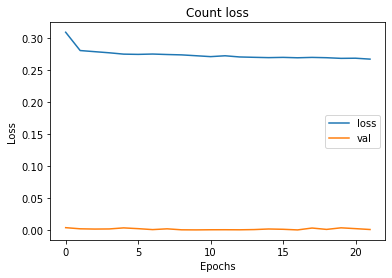

In [23]:
# plot loss during training
import matplotlib.pyplot as plt
plt.subplot()
plt.title('Count loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['count_output_loss'], label='loss')
plt.plot(history.history['val_count_output_loss'], label='val')
plt.legend()

<h3>Training: Class Output</h3>

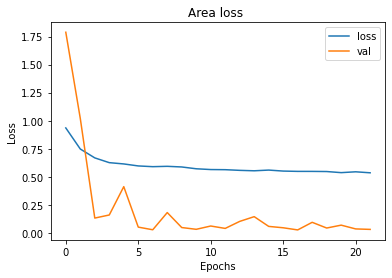

In [24]:
# plot loss during training
import matplotlib.pyplot as plt
plt.subplot()
plt.title('Area loss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['class_output_loss'], label='loss')
plt.plot(history.history['val_class_output_loss'], label='val')
plt.legend()

<h2>Evaluation Using Test Data</h2>

In [25]:
y_pred=model.predict(x_test)
count_predictions = y_pred[0]
area_predictions = y_pred[1]

Typically, when evaluating classifiers on imbalanced data, ROC AUC is not the preffered evaluation metric. Instead, a precision and recall curve would be used. In this case, this model was designed to outperform a statistical approach to the same problem (not shown in this notebook). The paper in question used ROC AUC to evaluate its perfromance (perhaps not the ideal measure) but in light of this, ROC AUC is also used here to enable direct comparison. 

<h3>Test: Count Output</h3>

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
count_auc = roc_auc_score(y_test_count, count_predictions)
print('NN: ROC AUC=%.6f' % (count_auc))

NN: ROC AUC=0.875489


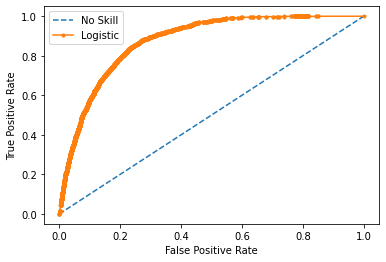

In [27]:
ns_probs = [0 for _ in range(len(y_test_count))]
ns_fpr, ns_tpr, _ = roc_curve(y_test_count, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_count, count_predictions)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

<h3>Test: Area Output</h3>

In [28]:
macro_roc_auc_ovo = roc_auc_score(y_test_area, area_predictions, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test_area, area_predictions, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test_area, area_predictions, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test_area, area_predictions, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.754180 (macro),
0.881380 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.873183 (macro),
0.873639 (weighted by prevalence)


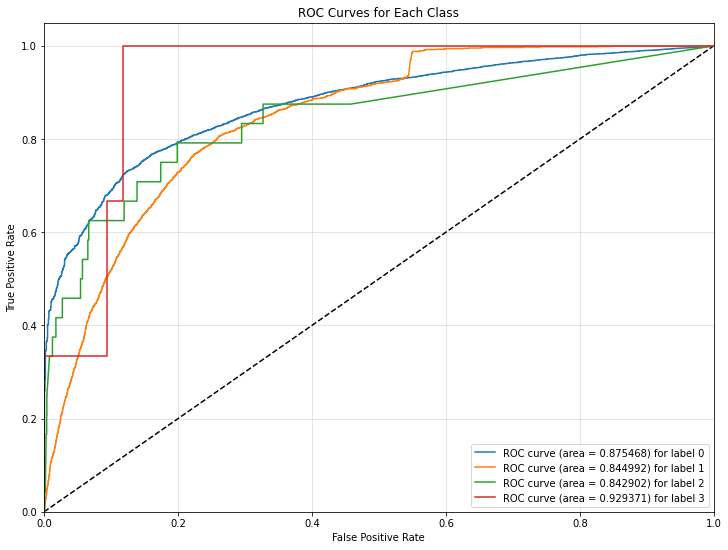

In [29]:
plot_multiclass_roc(y_test_area, area_predictions, n_classes=4, figsize=(12, 9))